#  Extracting text features

In [3]:
# Imports
import os
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline  
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [117]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
def walk_up_folder(path, depth=1):
    """
    Helper method to navigate the file system and get to the file location
    """
    _cur_depth = 1        
    while _cur_depth < depth:
        path = os.path.dirname(path)
        _cur_depth += 1
    return path

In [43]:
from gensim.parsing import PorterStemmer
global_stemmer = PorterStemmer()
 
class StemmingHelper(object):
    """
    Class to aid the stemming process - from word to stemmed form,
    and vice versa.
    The 'original' form of a stemmed word will be returned as the
    form in which its been used the most number of times in the text.
    """
 
    #This reverse lookup will remember the original forms of the stemmed
    #words
    word_lookup = {}
 
    @classmethod
    def stem(cls, word):
        """
        Stems a word and updates the reverse lookup.
        """
 
        #Stem the word
        stemmed = global_stemmer.stem(word)
 
        #Update the word lookup
        if stemmed not in cls.word_lookup:
            cls.word_lookup[stemmed] = {}
        cls.word_lookup[stemmed][word] = (
            cls.word_lookup[stemmed].get(word, 0) + 1)
 
        return stemmed
 
    @classmethod
    def original_form(cls, word):
        """
        Returns original form of a word given the stemmed version,
        as stored in the word lookup.
        """
 
        if word in cls.word_lookup:
            return max(cls.word_lookup[word].keys(),
                       key=lambda x: cls.word_lookup[word][x])
        else:
            return word

In [48]:
SH=StemmingHelper()
SH.stem("applies")

'appli'

In [9]:
data_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/product_desc_only.txt')
categories_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/product_categories.txt')

In [17]:
def loadDocument(filepath):
    """
    Load the cleaned data into a list for vectorizers
    :param filepath: Read all files in this location
    :return: Return a list of all the documents' contents
    """
    print("Loading document from processed files")
    with open(filepath, 'r', encoding="utf-8") as doc:
        content = doc.read()
    return content

In [94]:
documents = loadDocument(data_path)

Loading document from processed files


In [95]:
documents = documents.split('\n\n')

In [96]:
len(documents)

1000

In [97]:
documents

["supersoft speckled french terry makes this (tush covering!) turtleneck-sweatshirt hybrid the layering piece you'll want to wear to the gym, to lunch, to, well, everywhere this winter. loose fit. body length: 27 1/2. cotton. import.",
 'consider this embroidered layer your new dressy sweatshirt this winter. slim fit. body length: 24. cotton. import.',
 "shop the men's slim american pima cotton oxford shirt with mechanical stretch at j.crew and see the entire selection of men's casual shirts. free shipping available.",
 "shop the women's off-the-shoulder foldover top at j.crew and see the entire selection of women's knits. free shipping available.",
 "shop the women's ruffle plunge v-neck one-piece swimsuit at j.crew and see the entire selection of women's swimwear. free shipping available.",
 "shop the women's strappy knit midi dress at j.crew and see the entire selection of women's swimwear. free shipping available.",
 "shop the women's mixed stripe t-shirt at j.crew and see the enti

In [98]:
# Replacing missing values with unknown
for idx,desc in enumerate(documents):
    if desc=='':
        print(idx)
        documents[idx] = "UNK" 

116
200
227
231
234
264
283
284
287
293
294
299
310
311
324
333
340
356
365
391
392
393
394
395
404
409
444
453
454
502
670
715
718
748
749
760
769
802
903
929
940
943
945


In [99]:
documents[116]

'UNK'

In [100]:
sent = "this is a foo bar, bar black sheeps."
stop = stopwords.words('english') + list(string.punctuation)
[SH.stem(i) for i in word_tokenize(sent.lower()) if i not in stop]

['foo', 'bar', 'bar', 'black', 'sheep']

In [101]:
for idx,sent in enumerate(documents):
    documents[idx]=" ".join([SH.stem(i) for i in word_tokenize(sent.lower()) if i not in stop]).replace("'s","")

In [102]:
documents

["supersoft speckl french terri make tush cover turtleneck-sweatshirt hybrid layer piec 'll want wear gym lunch well everywher winter loos fit bodi length 27 1/2 cotton import",
 'consid embroid layer new dressi sweatshirt winter slim fit bodi length 24. cotton import',
 'shop men  slim american pima cotton oxford shirt mechan stretch j.crew see entir select men  casual shirt free ship avail',
 'shop women  off-the-should foldov top j.crew see entir select women  knit free ship avail',
 'shop women  ruffl plung v-neck one-piec swimsuit j.crew see entir select women  swimwear free ship avail',
 'shop women  strappi knit midi dress j.crew see entir select women  swimwear free ship avail',
 'shop women  mix stripe t-shirt j.crew see entir select women  knit free ship avail',
 'made supersoft slub cotton cut slightli slouchi fit t-shirt total summer must made bunch color feel free stock bodi length front 22 3/4 back 24 3/4 cotton machin wash. import',
 'easi heather t-shirt cute tie-back d

In [110]:
counts = Counter()
words = re.compile(r'\w+')
for sentence in documents:
    counts.update(words.findall(sentence.lower()))


In [112]:
counts.most_common(20)

[('women', 844),
 ('j', 580),
 ('select', 576),
 ('see', 569),
 ('avail', 564),
 ('shop', 561),
 ('crew', 561),
 ('ship', 554),
 ('entir', 549),
 ('free', 542),
 ('shirt', 219),
 ('cotton', 202),
 ('de', 170),
 ('wash', 157),
 ('import', 137),
 ('dress', 137),
 ('men', 136),
 ('size', 130),
 ('fit', 130),
 ('top', 121)]

In [115]:
vocab_size = len(counts)
vocab_size

4588

In [107]:
Counter(fullstring).keys()

dict_keys(['°', "'", 't', '0', '5', 'ß', '_', '8', 'u', 'h', '2', '|', 'ü', 'z', 'q', 'g', 'j', '=', 'f', '®', 'e', '7', 'ù', 'ç', ' ', 'à', '-', 'y', 'b', '”', '/', 'w', '+', 'c', 'é', '`', 'ô', 'ê', '6', 'a', '—', '–', 's', 'ö', '’', '9', '~', 'î', '.', 'â', 'l', 'x', 'œ', ',', 'm', '*', 'v', '\ufeff', 'i', 'n', '4', ':', '1', 'o', 'ï', '3', 'd', 'è', 'ä', 'k', 'r', '･', 'p', '™', 'û'])

In [108]:
remove = ['°', "'",'ß', '_','u', 'h', '|', 'ü','=', '®', 'ù', 'ç', 'à', '-', '”', '/', 'é', '`', 'ô', 'ê', '—', '–', 'ö', '’', '~', 'î', '.', 'â', 'œ', ',', '*', '\ufeff', ':', 'ï', 'è', 'ä', '･', '™', 'û']

In [119]:
numTopics =11
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=vocab_size, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

# Running
print("Running Latent Dirichlet Allocation")
t0 = time.time()
lda = LatentDirichletAllocation(n_topics=numTopics, max_iter=5, learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)
t1 = time.time()
print("Seconds for LDA: %.3f"%(t1 - t0))

Running Latent Dirichlet Allocation


/root/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Seconds for LDA: 1.015


In [121]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=11, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [122]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=vocab_size, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# Running
print("Running Non-negative Matrix Factorization")
t0 = time.time()
nmf = NMF(n_components=numTopics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
t1 = time.time()
print("Seconds for NMF: %.3f"%(t1 - t0))

Running Non-negative Matrix Factorization
Seconds for NMF: 0.191


In [130]:
tfidf

<1000x1899 sparse matrix of type '<class 'numpy.float64'>'
	with 18101 stored elements in Compressed Sparse Row format>

In [153]:
tfidfmatrix = np.squeeze(tfidf.toarray())

In [164]:
tfidfmatrix.shape

(1000, 1899)

In [165]:
tfidf_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/tfidf.dat')

In [166]:
tfidfmatrix.tofile(tfidf_path)
c = np.fromfile(tfidf_path)
c == tfidfmatrix

False

In [162]:
c

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [123]:
nmf

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=200, n_components=11, random_state=1, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [124]:
def display(model, feature_names, num_to_display):
    """
     Function to display the topics by their top words
    :param model:
    :param feature_names:
    :param num_to_display:
    :return:
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_to_display - 1:-1]]))

In [187]:
def save_fig(directory, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Method to save plots to the directory
    :param directory:
    :param fig_id:
    :param tight_layout:
    :param fig_extension:
    :param resolution:
    :return:
    """
    path = os.path.join(directory, fig_id + "." + fig_extension)
    print("Saving figure : " + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [188]:
img_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'static/plots')
if not os.path.exists(img_path):
    os.makedirs(img_path)


In [214]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import cycle, islice

num_clusters = 11
num_seeds = 11
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2


# tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
# tf_idf_matrix = tf_idf_vectorizer.fit_transform(texts_list)

# create k-means model with custom config
clustering_model = KMeans(n_clusters=num_clusters,max_iter=max_iterations,precompute_distances="auto", n_jobs=-1)

labels = clustering_model.fit_predict(tfidf)
# print labels
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(labels) + 1))))
X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

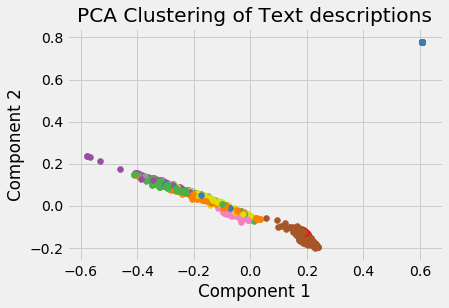

Saving figure : PCA2d


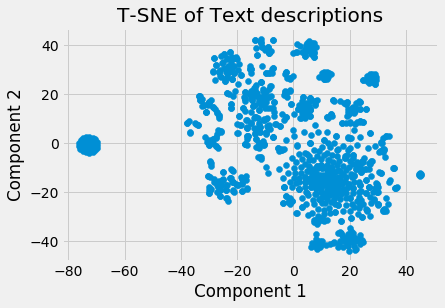

Saving figure : t-SNE2d


In [210]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = colors[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("PCA Clustering of Text descriptions")
plt.show()
save_fig(img_path,"PCA2d",False)


# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("T-SNE of Text descriptions")
plt.show()
save_fig(img_path,"t-SNE2d",False)


Saving figure : PCA3d


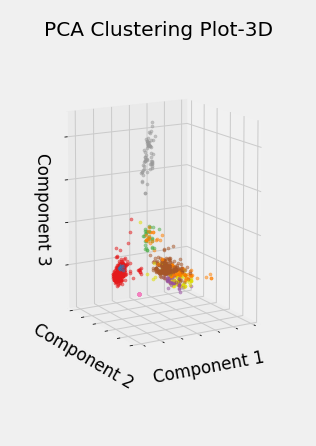

In [200]:
from mpl_toolkits.mplot3d import Axes3D
pca_num_components = 3
tsne_num_components = 3
reduced_data3 = PCA(n_components=pca_num_components).fit_transform(X)
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=10, azim=60)
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2,pca_comp3 = reduced_data3[index]
    color = colors[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2,pca_comp3, c=color,alpha=0.5, s=10)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('PCA Clustering Plot-3D')
ax.dist = 12
save_fig(img_path,"PCA3d",False)

IndexError: index 2 is out of bounds for axis 1 with size 2

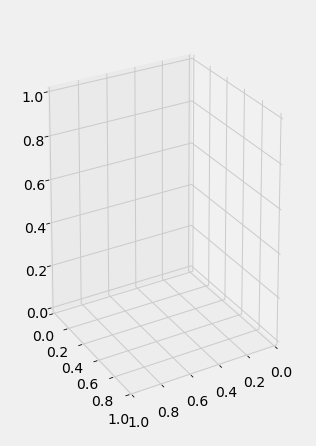

In [211]:
# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=20, azim=60)
ax.scatter(Y[:, 0], Y[:, 1],Y[:, 2], cmap=plt.cm.Spectral)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('T-SNE Plot-3D')
ax.dist = 12
save_fig(img_path,"T-SNE3d",False)

In [217]:
len(labels)

1000

In [215]:
labels

array([ 2,  2,  3, 10,  4,  4, 10,  2,  2,  2, 10, 10, 10, 10, 10,  2, 10,
       10, 10,  2,  2,  2,  2,  4,  4, 10,  4,  2,  4,  4,  4,  4,  2,  4,
        4,  4,  4,  4, 10,  4,  4,  4,  2, 10, 10,  4,  4,  4,  4,  4,  2,
        2,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8, 10,  5,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  7,  7,  7,  7,  7, 10, 10,
        7,  2, 10,  2,  7,  2,  7,  7,  7,  2,  1, 10,  2, 10, 10,  4,  4,
        2, 10,  4,  2, 10,  4, 10,  4,  4,  4, 10,  4,  0,  0,  9, 10, 10,
       10, 10, 10, 10,  2,  2,  2,  2,  2,  2, 10, 10,  3, 10, 10, 10, 10,
       10, 10,  1,  1,  2,  1,  2,  2,  2,  2, 10, 10, 10, 10,  2, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10,  2,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  2, 10, 10,  8,  2, 10,
        2, 10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10,  8,  9,  7,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  6,  6,  6,  6,  6,  5,  5,  6,  6,  6,
        2,  2,  6,  2,  6

In [216]:
label_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/labeltfidf.txt')

In [221]:
# Storing the labels into a separate file
with open(label_path, "w", encoding='utf-8') as target:
    for _ in range(len(labels)):
        target.write(str(labels[_]))
        target.write("\n")

In [127]:
display(lda,tf_feature_names,100)

Topic 0:
pom leather handmad heel itali sale spandex gold usa mother nylon belt item logo microfib italian embroid patent luxuri plate raw 28 po final arizaga venessa construct product 72 jewelri india polyest sued coast 589 slide gone mesh embroideri brass ajust tassel 24k fibr airbrush shimmeri en illumin commando dig gusset mixt hf05 76 fre bracelet flawless custom control 59 13 waistband sheen artisan la handl céramiqu bead beauti brazil trancoso positano sole sheer reflect insol cut cordon simpl upper flat machin season inspir et black 180 par featur recycl loafer calf make blend color touch glitter add tropic stylish
Topic 1:
underwear tush bodysuit gift snap becom cotton slim stick blank crewneck built dwh length madeworn bodi place import sweatshirt 611 mother wash cute sister 21 stapl fit machin perfectli distress shape women word select easi heather wear new entir avail fleec sai super crew shop jersei short ship free line perfect flatt minim sleev shirt boi textur everyth lo

In [128]:
display(nmf,tfidf_feature_names,100)

Topic 0:
women crew free ship entir avail shop select knit swimwear bikini stripe tie bag tank playa swimsuit wrap piec tote activ skirt sweatshirt intim sweater crop gingham neck ruch footwear underwir floral cew hipster french seersuck blazer pouch new rickrack straw nautic microfib set liberty pajama leg scoopneck long rash guard ruffl jean scoop pullov point bodysuit 365 supima print bandeau waist accessori balance cardigan sock leather tencel cotton loung necklac lowrid stretch swim sneaker high sandal linen string petit market scoopback transit strappi supersoft eyelet hat drapei 1989 tini esprit fleec zip larg ti plung loungewear signet canva trim
Topic 1:
unk été facial exquisit extend extens extra extract extrait extrem ey eyelet fabric fabriqué face facil expos fade fait fall famili famou fashion fasten faux favorit feat featherweight featur express expert feminin experiment erica espadril especi esprit essenti essuy est estella et ethylhexylglycerin eucalyptu euphorbia everi